In [1]:
import nltk
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100)     
pd.set_option('display.width', None)       
pd.set_option('display.max_colwidth', None) 


# Text Preprocessing

In [2]:

df = pd.read_csv('2700_stemmed.csv')
df1 = pd.read_csv('08_stemmed.csv')
df = pd.concat([df, df1])
df.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,text_processed1
0,1917717601666621522,Wed Apr 30 23:59:51 +0000 2025,0,@BosPurwa @prabowo Amit amit... Kejadian kayak...,1917730649655632285,https://pbs.twimg.com/media/Gpbyi5VbEAI_u4g.jpg,BosPurwa,in,NaN,1,1,1,https://x.com/edi_muchlis/status/1917730649655...,267240989,edi_muchlis,negatif,prabowo amit amit jadi kayak bikin kepala malu
1,1917730609520407002,Wed Apr 30 23:59:41 +0000 2025,2,Presiden Prabowo Bakal Pidato Poltik di May Da...,1917730609520407002,NaN,NaN,in,NaN,0,2,0,https://x.com/kompascom/status/191773060952040...,23343960,kompascom,netral,presiden prabowo pidato poltik may day monas m...
2,1917384942914527346,Wed Apr 30 23:59:40 +0000 2025,2,@ututututmkkk @AnKiiim_ @jokowi @prabowo Lepas...,1917730602545209555,NaN,ututututmkkk,in,NaN,0,0,0,https://x.com/ginanjarnur_p/status/19177306025...,3007773943,ginanjarnur_p,netral,prabowo lepas hidup dendam
3,1917714747690213459,Wed Apr 30 23:59:28 +0000 2025,0,@KamandanunGaPak Sayang nya pak presiden @prab...,1917730552284918244,NaN,KamandanunGaPak,in,NaN,0,0,0,https://x.com/routers40525/status/191773055228...,1675011538460229633,routers40525,negatif,sayang presiden prabowo subianto hina preman h...
4,1917529672885362830,Wed Apr 30 23:59:13 +0000 2025,0,@kompascom Heran..kok bisa balas dendam ya..pd...,1917730490083336199,NaN,kompascom,in,NaN,0,0,0,https://x.com/mmymurni/status/1917730490083336199,34194525,mmymurni,negatif,heran balas dendam pdhl udah pensiun pegang ke...


In [52]:
df.describe()

,favorite_count,quote_count,reply_count,retweet_count,Unnamed: 0
count,5995.000000,5995.000000,5995.000000,5995.000000,3213.000000
mean,598.230692,18.346455,58.191827,166.020350,2971.671646
std,2671.705743,133.897401,171.721100,707.458069,2260.638078
min,0.000000,0.000000,0.000000,0.000000,456.000000
25%,0.000000,0.000000,0.000000,0.000000,1259.000000
50%,38.000000,0.000000,2.000000,6.000000,2062.000000
75%,298.000000,6.000000,40.000000,72.000000,3579.000000
max,69918.000000,4441.000000,2915.000000,17464.000000,12187.000000


In [3]:
df['label'].value_counts()

label
positif    3856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64

In [4]:
df.duplicated().sum()

0

In [5]:
# 1. Pisahkan data negatif dan data lainnya
df_negatif = df[df['label'] == 'positif']
df_lainnya = df[df['label'] != 'positif']

# 2. Ambil sisa data negatif yang ingin dipertahankan
df_negatif_tersisa = df_negatif.sample(n=len(df_negatif) - 1000, random_state=42)

# 3. Gabungkan kembali dengan data lainnya
df = pd.concat([df_negatif_tersisa, df_lainnya], ignore_index=True)

# 4. Cek hasil
print(df['label'].value_counts())

label
positif    2856
negatif    2843
netral     1644
campur        1
Name: count, dtype: int64


In [71]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Inisialisasi stemmer dan stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

# Mention penting yang ingin disimpan (whitelist)
mention_whitelist = ['prabowo']

# Kamus normalisasi kata informal → formal
normalisasi_kata = {
    'gak': 'tidak',
    'ga': 'tidak',
    'yg': 'yang',
    'utk': 'untuk',
    'dgn': 'dengan',
    'apik': 'baik',
    'sdh': 'sudah',
    'krn': 'karena',
    'apik': 'bagus',
    'tdk': 'tidak',
    'klo': 'kalo',
    'sbg': 'sebagai',
    'gue': 'aku',
    'dlm': 'dalam',
    'jgn': 'jangan',
    'jkw': 'jokowi',
    'org': 'orang',
    'nggak': 'tidak',
    'aja': '',
    'amp': '',
    'nya': '',
    'ya': '',
    'gitu': '',
    'loh': '',
    'dong': '',
    'sih': '',
    'deh': '',
    'nih': '',
    'kok': '',
}

def preprocessing(text):
    # 2. Tangani mention: simpan jika ada di whitelist, hapus lainnya
    text = re.sub(r'@(\w+)', lambda m: m.group() if m.group(1).lower() in mention_whitelist else '', text)

    text = re.sub(r'http\S+|www\S+|<.*?>|#', ' ', text)
    
    # 4. Hapus tag HTML (jika ada)
    text = re.sub(r'<.*?>', '', text)

    # 5. Hapus karakter non-huruf (angka, simbol)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # 6. Lowercase
    text = text.lower()

    # 7. Tokenisasi
    tokens = word_tokenize(text)

    # 8. Normalisasi kata informal
    tokens = [normalisasi_kata.get(word, word) for word in tokens]

    # 9. Hapus stopwords dan kata kosong/panjang pendek
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2 and word != '']

    # 11. Gabung kembali jadi string
    return ' '.join(tokens)


In [72]:
def apply_with_progress(df, func, column, new_column, step=50):
    result = []
    for i, text in enumerate(df[column]):
        result.append(func(text))
        if (i + 1) % step == 0 or (i + 1) == len(df):
            print(f"Processed {i + 1}/{len(df)} rows")
    df[new_column] = result
    return df

# Contoh pemakaian
df = apply_with_progress(df, preprocessing, 'full_text', 'text_processed')
df.head()


Processed 50/2782 rows
Processed 100/2782 rows
Processed 150/2782 rows
Processed 200/2782 rows
Processed 250/2782 rows
Processed 300/2782 rows
Processed 350/2782 rows
Processed 400/2782 rows
Processed 450/2782 rows
Processed 500/2782 rows
Processed 550/2782 rows
Processed 600/2782 rows
Processed 650/2782 rows
Processed 700/2782 rows
Processed 750/2782 rows
Processed 800/2782 rows
Processed 850/2782 rows
Processed 900/2782 rows
Processed 950/2782 rows
Processed 1000/2782 rows
Processed 1050/2782 rows
Processed 1100/2782 rows
Processed 1150/2782 rows
Processed 1200/2782 rows
Processed 1250/2782 rows
Processed 1300/2782 rows
Processed 1350/2782 rows
Processed 1400/2782 rows
Processed 1450/2782 rows
Processed 1500/2782 rows
Processed 1550/2782 rows
Processed 1600/2782 rows
Processed 1650/2782 rows
Processed 1700/2782 rows
Processed 1750/2782 rows
Processed 1800/2782 rows
Processed 1850/2782 rows
Processed 1900/2782 rows
Processed 1950/2782 rows
Processed 2000/2782 rows
Processed 2050/2782 

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username,label,text_processed
0,1917717601666621522,Wed Apr 30 23:59:51 +0000 2025,0,@BosPurwa @prabowo Amit amit... Kejadian kayak begini bikin dia besar kepala memalukan https://t.co/U7co7mDUDr,1917730649655632285,https://pbs.twimg.com/media/Gpbyi5VbEAI_u4g.jpg,BosPurwa,in,NaN,1,1,1,https://x.com/edi_muchlis/status/1917730649655632285,267240989,edi_muchlis,negatif,prabowo amit amit kejadian kayak bikin kepala memalukan
1,1917730609520407002,Wed Apr 30 23:59:41 +0000 2025,2,Presiden Prabowo Bakal Pidato Poltik di May Day Monas Naik Maung dari Istana | #Prabowo #HariBuruh #Mayday https://t.co/QCQmfxFRpF,1917730609520407002,NaN,NaN,in,NaN,0,2,0,https://x.com/kompascom/status/1917730609520407002,23343960,kompascom,netral,presiden prabowo pidato poltik may day monas maung istana prabowo hariburuh mayday
2,1917384942914527346,Wed Apr 30 23:59:40 +0000 2025,2,@ututututmkkk @AnKiiim_ @jokowi @prabowo Lepaskan hidup dari dendam,1917730602545209555,NaN,ututututmkkk,in,NaN,0,0,0,https://x.com/ginanjarnur_p/status/1917730602545209555,3007773943,ginanjarnur_p,netral,prabowo lepaskan hidup dendam
3,1917714747690213459,Wed Apr 30 23:59:28 +0000 2025,0,@KamandanunGaPak Sayang nya pak presiden @prabowo subianto tidak merasa terhina ketika preman menghina purnawirawan bau tanah sekelas pak sutyoso pendidikan militer dan pencapaian nya luar biasa seenak nya di hina oleh preman di biarkan oleh Presiden seakan situasi ini sengaja diciptakan ?,1917730552284918244,NaN,KamandanunGaPak,in,NaN,0,0,0,https://x.com/routers40525/status/1917730552284918244,1675011538460229633,routers40525,negatif,sayang presiden prabowo subianto terhina preman menghina purnawirawan bau tanah sekelas sutyoso pendidikan militer pencapaian seenak hina preman biarkan presiden seakan situasi sengaja diciptakan
4,1917529672885362830,Wed Apr 30 23:59:13 +0000 2025,0,@kompascom Heran..kok bisa balas dendam ya..pdhl dia udah pensiun berarti masih tetap pegang kendali pemerintahan yg .dipimin prabowo,1917730490083336199,NaN,kompascom,in,NaN,0,0,0,https://x.com/mmymurni/status/1917730490083336199,34194525,mmymurni,negatif,heran balas dendam pdhl udah pensiun pegang kendali pemerintahan dipimin prabowo


In [73]:
from collections import Counter
import re

df_copy = df.copy()

# Gabungkan semua teks jadi satu string
text = ' '.join(df_copy['text_processed'].astype(str))

# Preprocessing: lowercase + tokenisasi
words = re.findall(r'\b\w+\b', text.lower())

# Hitung frekuensi kata
freq = Counter(words)

# Ambil 50 kata paling sering
top_50 = freq.most_common(150)

# Cetak hasil
for word, count in top_50:
    print(f"{word}: {count}")


prabowo: 2830
tppbersamamenteridesa: 1086
merah: 726
putih: 721
pembentukan: 706
koperasi: 705
musdesus: 647
presiden: 359
jokowi: 174
indonesia: 167
preman: 158
orang: 152
gratis: 144
negara: 138
program: 122
rakyat: 116
kalo: 108
kesehatan: 107
tni: 98
gibran: 97
danantara: 95
cek: 86
ormas: 83
anak: 76
desa: 76
makan: 76
mbg: 73
bikin: 70
udah: 64
hercules: 63
sehat: 60
semoga: 58
banget: 57
haris: 56
yocku: 55
pemerintah: 52
ijazah: 49
berani: 47
jayapura: 46
biar: 44
negeri: 43
kasih: 43
hidup: 41
buruh: 40
grib: 40
bandung: 39
kerja: 38
hukum: 38
subianto: 37
dukung: 37
coba: 36
palsu: 36
menteri: 36
kayak: 35
salah: 35
masyarakat: 35
percaya: 35
bergizi: 35
bilang: 34
takut: 33
emang: 33
may: 32
day: 32
pemerintahan: 32
kalah: 32
bangsa: 32
gimana: 32
tuh: 32
semangat: 32
purnawirawan: 31
panglima: 31
sukses: 31
juta: 31
bawa: 31
polisi: 29
mulyono: 29
solusi: 29
mantan: 28
langkah: 28
tau: 28
tolol: 27
wapres: 27
jabatan: 26
diam: 26
pemimpin: 26
omon: 25
jendral: 25
langsung: 

In [6]:
df.loc[df['label'] == 'campur', 'label'] = 'netral'


In [9]:
import pandas as pd

# Misal df1 dan df2 sudah ada dan punya kolom yang sama
df['label_num'] = df['label'].replace({'netral' : 0, 'positif' : 1, 'negatif' : 2})
df['label_num'].value_counts()

label_num
1    2856
2    2843
0    1645
Name: count, dtype: int64

In [11]:
df = df.rename(columns={'text_processed1': 'text_processed'})
df = df.dropna(subset=['text_processed'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7341 entries, 0 to 7343
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      7341 non-null   int64  
 1   created_at               7341 non-null   object 
 2   favorite_count           7341 non-null   int64  
 3   full_text                7341 non-null   object 
 4   id_str                   7341 non-null   int64  
 5   image_url                1906 non-null   object 
 6   in_reply_to_screen_name  3781 non-null   object 
 7   lang                     7341 non-null   object 
 8   location                 0 non-null      float64
 9   quote_count              7341 non-null   int64  
 10  reply_count              7341 non-null   int64  
 11  retweet_count            7341 non-null   int64  
 12  tweet_url                7341 non-null   object 
 13  user_id_str              7341 non-null   int64  
 14  username                 2646

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# 1. Inisialisasi dan fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text_processed'])

# 2. Tentukan MAX_WORDS berdasarkan jumlah kata unik
total_kata_unik = len(tokenizer.word_index)
print("Jumlah kata unik:", total_kata_unik)

# Atur MAX_WORDS agar tidak terlalu besar
if total_kata_unik > 20000:
    MAX_WORDS = 15000
elif total_kata_unik > 10000:
    MAX_WORDS = total_kata_unik
else:
    MAX_WORDS = total_kata_unik

print("MAX_WORDS yang digunakan:", MAX_WORDS)

Jumlah kata unik: 8786
MAX_WORDS yang digunakan: 8786


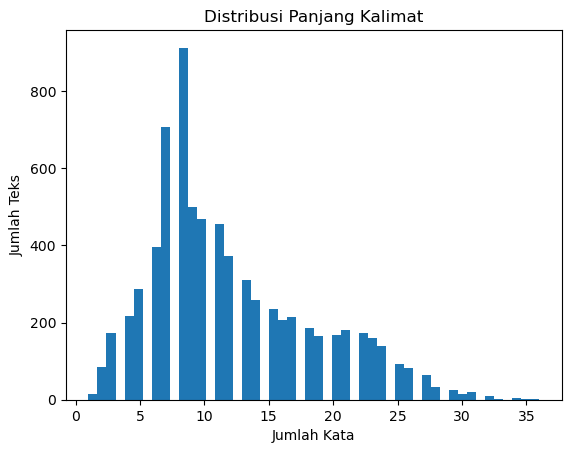

MAX_LEN (persentil 95): 36


In [13]:
# 3. Hitung panjang tiap kalimat
sequences = tokenizer.texts_to_sequences(df['text_processed'])
panjang_kalimat = [len(seq) for seq in sequences]

# 4. Tentukan MAX_LEN berdasarkan distribusi panjang
plt.hist(panjang_kalimat, bins=50)
plt.title('Distribusi Panjang Kalimat')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Teks')
plt.show()

MAX_LEN = int(np.percentile(panjang_kalimat, 100))
print("MAX_LEN (persentil 95):", MAX_LEN)

In [14]:
# 5. Lakukan ulang tokenizer dengan batasan MAX_WORDS
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_processed'])
sequences = tokenizer.texts_to_sequences(df['text_processed'])

# 6. Padding sequences
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [15]:
df['label_num'].value_counts()

label_num
1    2855
2    2843
0    1643
Name: count, dtype: int64

# Feature Engineering

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['label_num'], test_size=0.3, random_state=42, stratify=df['label_num']
)
y_train.value_counts(), y_test.value_counts()

(label_num
 1    1998
 2    1990
 0    1150
 Name: count, dtype: int64,
 label_num
 1    857
 2    853
 0    493
 Name: count, dtype: int64)

# Model Architecture Definition

# Training Model

In [17]:
import numpy as np
print(np.unique(y_train, return_counts=True))  # Cek distribusi kelas

(array([0, 1, 2], dtype=int64), array([1150, 1998, 1990], dtype=int64))


In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.4892753623188406, 1: 0.8571905238571905, 2: 0.8606365159128978}

In [19]:
import numpy as np
from gensim.models import KeyedVectors

# Load model FastText Bahasa Indonesia
fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', limit=50000)  # optional limit

# Buat embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((MAX_WORDS, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        if word in fasttext_model:
            embedding_matrix[i] = fasttext_model[word]
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)  # fallback


FileNotFoundError: [Errno 2] No such file or directory: 'cc.id.300.vec'

In [20]:
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, SimpleRNN, Conv1D, GlobalMaxPooling1D, Flatten
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional  
from keras import regularizers  
from keras.optimizers import Adam, RMSprop, SGD
from keras.metrics import Recall, Precision
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


model = Sequential()
model.add(Embedding(
    input_dim=MAX_WORDS,      
    output_dim=64,  
    input_length=MAX_LEN,      
    trainable=True           
))
model.add(Flatten())  # Rata-rata semua vektor kata jadi 1D vektor

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.5)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(3, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',         
    monitor='val_loss',               
    save_best_only=True,             
    mode='min',                      
    verbose=1                       
)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  
    restore_best_weights=True
)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights  
)

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 26.5189 - accuracy: 0.4362
Epoch 1: val_loss improved from inf to 8.77663, saving model to best_model.h5
81/81 [==============================] - 3s 15ms/step - loss: 26.5189 - accuracy: 0.4362 - val_loss: 8.7766 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 2/100
75/81 [==========================>...] - ETA: 0s - loss: 5.7837 - accuracy: 0.5671
Epoch 2: val_loss improved from 8.77663 to 3.75993, saving model to best_model.h5
81/81 [==============================] - 1s 14ms/step - loss: 5.6442 - accuracy: 0.5714 - val_loss: 3.7599 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 2.2713 - accuracy: 0.7530
Epoch 3: val_loss improved from 3.75993 to 1.92973, saving model to best_model.h5
81/81 [==============================] - 1s 15ms/step - loss: 2.2713 - accuracy: 0.7530 - val_loss: 1.9297 - val_accuracy: 0.7186 - lr: 0.0010
Epoch 4/100
77/81 [=======================

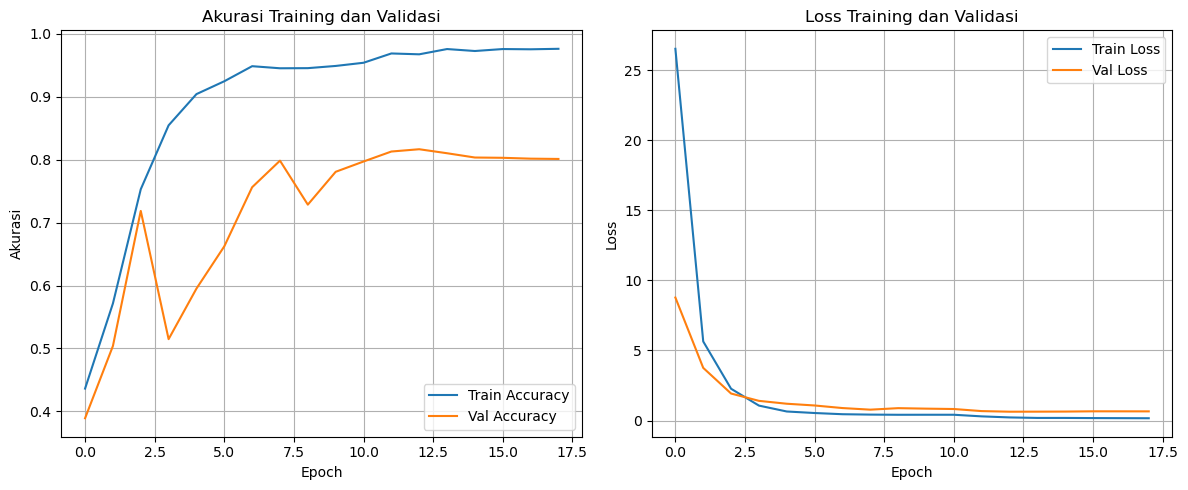

In [21]:
import matplotlib.pyplot as plt

# Ambil data dari history
history_dict = history.history

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


69/69 [==============================] - 1s 6ms/step


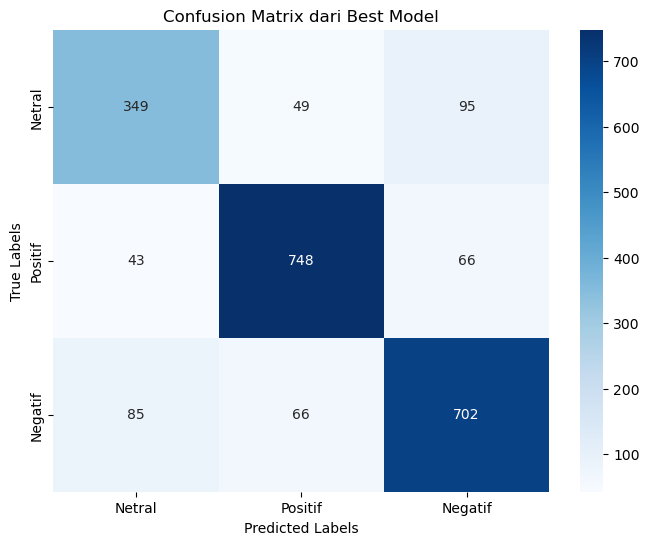

              precision    recall  f1-score   support

      Netral       0.73      0.71      0.72       493
     Positif       0.87      0.87      0.87       857
     Negatif       0.81      0.82      0.82       853

    accuracy                           0.82      2203
   macro avg       0.80      0.80      0.80      2203
weighted avg       0.82      0.82      0.82      2203



In [22]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load model terbaik
# best_model = load_model("best_model.h5")

# Prediksi dengan model terbaik
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Netral', 'Positif', 'Negatif']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix dari Best Model')
plt.show()

# Laporan klasifikasi
print(classification_report(y_test, y_pred, target_names=class_names))


In [23]:
import os
print(os.cpu_count())

16
